https://www.kaggle.com/vincentlugat/lightgbm-plotly

In [1]:
# Python libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore')

In [2]:
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [3]:
data = pd.read_csv('creditcard.csv')
data.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,182545,125447.0,1.816429,0.146354,0.046576,3.598831,-0.119489,0.764143,-0.673691,0.375930,...,0.235474,0.539597,0.240714,0.691290,-0.349606,-0.055401,-0.011830,-0.033766,18.92,0
1,264950,161666.0,-1.132632,-0.217753,-1.018984,-0.725154,1.624606,-1.123202,0.151016,0.322056,...,0.439623,0.855120,-0.058180,0.115257,-0.786822,0.591033,0.308595,0.055496,24.95,0
2,278614,168323.0,1.754189,0.230348,0.019154,3.927093,-0.087202,0.227146,-0.115704,0.053371,...,-0.374842,-1.136878,0.441901,-0.183241,-0.580846,-0.508929,-0.005608,-0.019285,64.40,0
3,10160,15578.0,1.028419,0.252588,1.744422,2.801771,-0.613426,0.860407,-0.849896,0.375564,...,-0.148324,-0.044123,0.103698,0.142224,0.132222,-0.080803,0.026917,0.016913,0.00,0
4,64,42.0,-0.522666,1.009923,0.276470,1.475289,-0.707013,0.355243,1.559849,-0.399579,...,0.172401,1.011543,0.069666,0.157820,-1.109224,-0.302369,0.318170,0.316910,243.66,0


#### 这个厉害诶，都不用username & password的

In [4]:
fraud = data[(data['Class'] != 0)]
normal = data[(data['Class'] == 0)]

trace = go.Pie(labels = ['Normal', 'Fraud'], values = data['Class'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of target variable')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

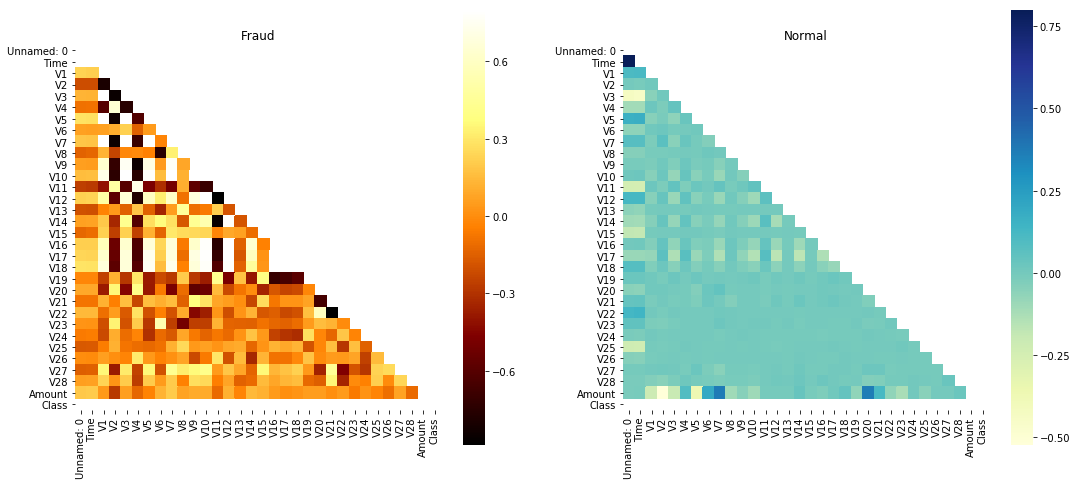

In [6]:
# Correlation matrix 
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 18, 8))
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap((data.loc[data['Class'] ==1]).corr(), vmax = .8, square=True, ax = ax1, cmap = 'afmhot', mask=mask);
ax1.set_title('Fraud')
sns.heatmap((data.loc[data['Class'] ==0]).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu', mask=mask);
ax2.set_title('Normal')
plt.show()

In [7]:
# Normalization Amount
from sklearn.preprocessing import StandardScaler
data['nAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
# Drop useless variables
data = data.drop(['Amount','Time'],axis=1)

# def X and Y
y = np.array(data.Class.tolist())
data = data.drop('Class', 1)
X = np.array(data.values)

# Train_test split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = random_state, stratify = y)

### Define model performance

In [8]:
def model_performance(model) : 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_pred) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #Feature importance
    coefficients  = pd.DataFrame(eval(model).feature_importances_)
    column_data   = pd.DataFrame(list(data))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))
    
    #Cumulative gain
    pos = pd.get_dummies(y_test).as_matrix()
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        name = "Lift curve",
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=4, cols=2, print_grid=False, 
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        'Cumulative gains curve',
                                        'Feature importance',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

## LightGBM Model

### LightGBM - Before RandomizedSearchCV

In [9]:
%%time
lgbm_clf = lgbm.LGBMClassifier(n_estimators=100, random_state = 42)

lgbm_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]

CPU times: user 8.38 s, sys: 1.24 s, total: 9.62 s
Wall time: 3.66 s


In [10]:
model_performance('lgbm_clf')

### 额，差到极点。。。

### LightGBM - After RandomizedSearchCV

In [11]:
%%time
lgbm_clf = lgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.48885215797203996, importance_type='split',
        learning_rate=0.1, max_depth=-1, metric='None',
        min_child_samples=180, min_child_weight=1e-05, min_split_gain=0.0,
        n_estimators=5000, n_jobs=4, num_leaves=7, objective=None,
        random_state=42, reg_alpha=0.1, reg_lambda=5, silent=True,
        subsample=0.2411830009999915, subsample_for_bin=200000,
        subsample_freq=0, scale_pos_weight = 1)

lgbm_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]

CPU times: user 1min 17s, sys: 8.36 s, total: 1min 26s
Wall time: 34.8 s


In [12]:
model_performance('lgbm_clf')

### 好多了。。。

### LightGBM - Cross validation - 5 folds [F1 score]

In [13]:
scores = cross_val_score(lgbm_clf, X, y, scoring = 'f1', cv=5)
trace = go.Table(
    header=dict(values=['<b>F1 score mean<b>', '<b>F1 score std<b>'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['center'],
                font = dict(size = 15)),
    cells=dict(values=[np.round(scores.mean(),6),
                       np.round(scores.std(),6)],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['center'], font = dict(size = 15)))

layout = dict(width=800, height=500, title = 'Cross validation - 5 folds [F1 score]', font = dict(size = 15))
fig = dict(data=[trace], layout=layout)
py.iplot(fig, filename = 'styled_table')